<h1>TP Datos - Análisis exploratorio de datos</h1>
<p>El presente trabajo es un análisis exploratorio de datos basado en las publicaciones de venta de propiedades, publicadas en un lapso de 4 años, proporcionadas por la empresa <a href="http://www.properati.com.ar/">Properati</a></p>

In [2]:
%matplotlib inline

import matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from os import listdir
from os.path import isfile, join
import calendar
import geopandas as gpd
from shapely.geometry import Point
from shapely.geometry import Polygon
from scipy import ndimage
import shapely


plt.style.use('default') # haciendo los graficos un poco mas bonitos xD
plt.rcParams['figure.figsize'] = (5, 5)

# Filtrado  de datos de los archivos CSV de cada mes

<p>Aquí declaramos algunas funciones útiles que usaremos para poder realizar un chequeo de consistencia sobre el cálculo de los precios de las propiedades en venta.</p>

In [4]:
# Filtro de propiedades con precio calculable. Devuelve 1 si es válido. De lo contrario, nan (Not A Number)
def filter(array):
    priceUSD, usdM2, surfaceTotal = array
    if np.isnan(surfaceTotal) or surfaceTotal == 0:
        return np.nan
    if not np.isnan(priceUSD) and not np.isnan(usdM2):
        price = usdM2 * surfaceTotal
        dif = abs(price - priceUSD)
        if ((dif / priceUSD) * 100) <= 10:
            return 1
    return 1

# Cálculo del precio aproximado de venta
def fillPrice(array):
    priceUSD, usdM2, surfaceTotal = array
    if np.isnan(priceUSD) and not np.isnan(usdM2):
        return (usdM2 * surfaceTotal)
    return priceUSD

# Cálculo del precio del metro cuadrado
def fillM2(array):
    priceUSD, usdM2, surfaceTotal = array
    if not np.isnan(priceUSD) and np.isnan(usdM2):
        return (priceUSD / surfaceTotal)
    return usdM2

# Hacemos un rápido chequeo de los archivos para saber si alguno se descargó mal

In [ ]:
"""
# Ruta de la carpeta con los archivos de datos originales
rutaCarpetaOriginales = "./properties/"
for archive in listdir(rutaCarpetaOriginales):
    if ".csv" in archive:
        nombreArchivo = rutaCarpetaOriginales + archive
        try:
            print nombreArchivo
            df = pd.read_csv(nombreArchivo, low_memory = False)
            print('Ok')
        except ValueError:
            print("Error, archivo corrupto. Descargar de nuevo")"""

# Filtrado y concatenacion de todos los archivos CSV en un solo archivo

En esta parte del código se filtraron columnas de los archivos csv que no ibamos a a usar. Tambiénse filtraron propiedades que no pertenezcan a Capital Federal o Gran Buenos Aires, ya que solo vamos a acotar nuestro análisis a estos dos lugares. Tambien fué necesario renombrar la columna de superficie ya que algunos archivos CSV tenian nombres distintos y es necesario que todos refieran al mismo.
Luego agregamos la columna llamada Date la cual refiere a la fecha en la cualfue publicada cada propiedad. Se uso esta fecha ya que la columna 'created_on' no refleja laevolucion del precio de las propiedades en funcion del tiempo y distorciona el analisis de datos. En cambio la fecha de publicacion muestra la actualizacion a la fecha de los precios de cada propiedad.

Tambien se filtraron porpiedades en función de la validez de sus datos. Es decir, que si el valor en dolares por metro cuadradro multiplicado por la superficie no se encontraba en un rango menor al 10% respecto del precio en dolares, se descartaban.
Finalmente concatenamos todos los archivos abiertos los cuales fueron almacenados en un vector de DataFrames. Se tiene que tener en cuenta que al realizar la concatenación se crearon cien columnas vacias con nombre "unnmaed: 0" a  "unnmaed: 99" por lo cual se tuvieron que eliminar del dataframe concatenado.
Luego grabamos el DataFrame concatenado en un archivo CSV para trabajar de ahora en mas con este ultimo

In [ ]:
"""# Ruta de la carpeta con los archivos de datos modificados
root = "./properties/"
properties = []
indexAcum = 0
for archive in listdir(root):
    if ".csv" not in archive:
        continue
    df = pd.read_csv(root + archive, low_memory = False)
    df = df.loc[df.place_with_parent_names.str.contains('Capital Federal') | df.place_with_parent_names.str.contains('Bs.As. G.B.A.'), :]
    
    # Durante la carga de datos, se eliminan ciertas columnas que nos resultan irrelevantes para el trabajo,
    # como urls.
    if 'properati_url' in df:
        df.drop('properati_url', axis = 1, inplace = True)
    if 'geonames_id' in df:
        df.drop('geonames_id', axis = 1, inplace = True)
    if 'description' in df:
        df.drop('description', axis = 1, inplace = True)
    if 'image_thumbnail' in df:
        df.drop('image_thumbnail', axis = 1, inplace = True)
    if 'operation' in df:
        df.drop('operation', axis = 1, inplace = True)
    if 'created_on' in df:
        df.drop('created_on', axis = 1, inplace = True)
    if 'lat-lon' in df:
        df.drop('lat-lon', axis = 1, inplace = True)
    if 'currency' in df:
        df.drop('currency', axis = 1, inplace = True)
    if 'title' in df:
        df.drop('title', axis = 1, inplace = True)
    if 'id' in df:
        df.drop('id', axis = 1, inplace = True)
    if 'price_aprox_local_currency' in df:
        df.drop('price_aprox_local_currency', axis = 1, inplace = True)
    if 'price_aprox_usd' in df and 'price' in df:
        df.drop('price', axis = 1, inplace = True)
    if 'extra' in df and 'price' in df:
        df.drop('extra', axis = 1, inplace = True)

    # En algunos casos, es necesario renombrar algunas columnas
    if 'price_aprox_usd' not in df:
        df.rename(columns = {'price': 'price_aprox_usd'}, inplace = True)
    if 'surface_total_in_m2' not in df:
        df.rename(columns = {'surface_in_m2': 'surface_total_in_m2'}, inplace = True)

    # Aquí reconvertimos algunas columnas a punto flotante
    df.loc[:, 'price_aprox_usd'] = df.loc[:, ['price_aprox_usd']].apply(lambda x: float(x), axis = 1)
    df.loc[:, 'price_usd_per_m2'] = df.loc[:, ['price_usd_per_m2']].apply(lambda x: float(x), axis = 1)

    # obtenemos el año y mes del nombre de archivo
    date_splitted = archive.split('-')
    month = date_splitted[3]
    year = date_splitted[2]
    date = year + '-' + month
    size = len(df.index)
    dates = pd.Series([date for i in range(0, size)])
    # y lo ponemos como dato en una columna
    df['date'] = dates
    df.loc[:, ['date']] = pd.to_datetime(df['date'], errors = 'coerce')

    # Aquí aplicamos el filtro antes declarado
    df['filter'] = df.loc[:, ['price_aprox_usd', 'price_usd_per_m2', 'surface_total_in_m2']].apply(filter, axis = 1)
    df = df[~np.isnan(df['filter'])]
    df.loc[:, ['price_aprox_usd']] = df.loc[:, ['price_aprox_usd', 'price_usd_per_m2', 'surface_total_in_m2']].apply(fillPrice, axis = 1)
    df.loc[:, ['price_usd_per_m2']] = df.loc[:, ['price_aprox_usd', 'price_usd_per_m2', 'surface_total_in_m2']].apply(fillM2, axis = 1)
    df.drop('filter', axis = 1, inplace = True)

    # Finalmente, guardamos los archivos modificados.
    size = len(df.index)
    if size != 0:
        indexAcum += size
        newIndex = [i for i in range(indexAcum, indexAcum+size)]
        df.reindex(newIndex)
        print archive
        properties.append(df)
                 
#Genero un nuevo csvcon la concatenacion de todos ellos en uno solo
general = pd.concat(properties)

#Borro las columnas vacias
for column in general.columns.values:
    if 'Unnamed' not in column:
        continue
    general.drop(column, axis = 1, inplace = True)

general.loc[:, ['date']] = pd.to_datetime(general['date'], errors = 'coerce')

#Grabo la concatenacion en un unico csv
try:
    general.to_csv("propertiesConCat.csv", index = True, header = True, sep = ',', encoding = 'utf-8-sig')
    print('Done')
except value:
    print('Error')"""

In [21]:
"""# Aquí levantamos el archivo generado y reducimos su tamaño si es necesario
df = pd.read_csv("propertiesConCat.csv", low_memory = False)

#Borramos la columna "extra"
if 'extra' in df:
    df.drop('extra', axis = 1, inplace = True)
    
#Borramos la columna "Unnamed: 0"
df.drop(df.columns.values[0], axis = 1, inplace = True)

#Volvemos a guardar los cambios en el archivo csv
df.to_csv("propertiesConCat.csv", index = True, header = True, sep = ',', encoding = 'utf-8-sig')"""

# Se abre el archivo csv concatenado

In [3]:
#Abrimos el dataframe unificado
df = pd.read_csv("propertiesConCat.csv", low_memory = False)

# Mostramos como varia el precio año a año de Capital Federal

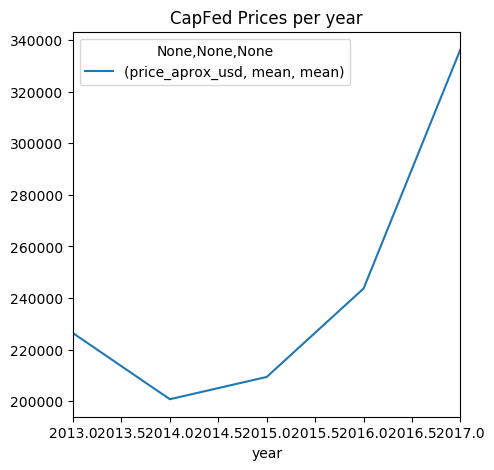

In [68]:
CF = df.loc[df.place_with_parent_names.str.contains('Capital Federal'), :]
CF = CF.loc[:, ['date', 'price_aprox_usd']].groupby('date').agg([np.mean, np.size]).reset_index()
CF.loc[:, ['date']] = pd.to_datetime(CF['date'], errors = 'coerce')
CF['year'] = CF['date'].dt.year
CFYear = CF.loc[:, [('year', ''), ('price_aprox_usd', 'mean')]].groupby('year').agg([np.mean, np.size]).reset_index()
CFYear.plot(x='year', y=('price_aprox_usd', 'mean', 'mean') , kind='line', title="CapFed Prices per year")

# Mostramos como varia el precio mes a mes de Capital Federal

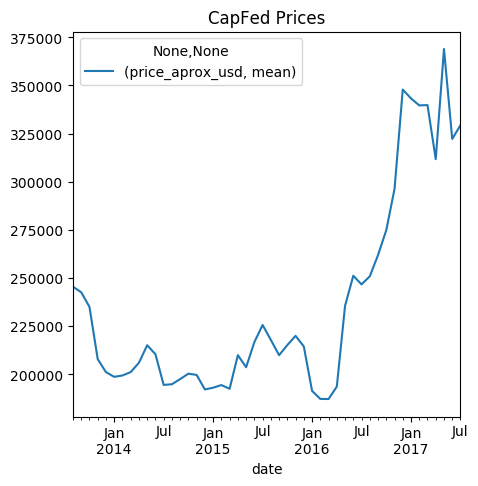

In [72]:
CF.plot(x='date', y=('price_aprox_usd', 'mean') , kind='line', title="CapFed Prices")

# Mostramos como varia el precio año a año de Gran Buenos Aires

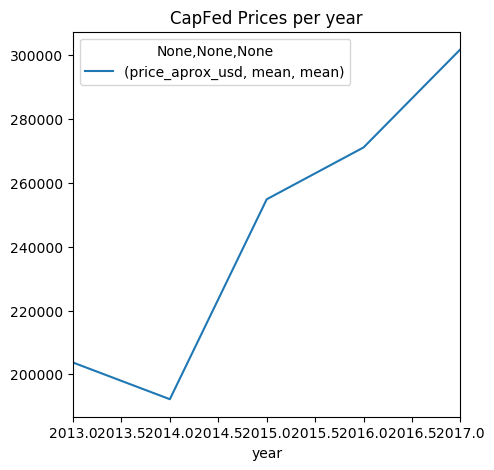

In [76]:
GBA = df.loc[df.place_with_parent_names.str.contains('Bs.As. G.B.A.'), :]
GBA = GBA.loc[:, ['price_aprox_usd', 'date']].groupby('date').agg([np.mean, np.size]).reset_index()
GBA.loc[:, ['date']] = pd.to_datetime(GBA['date'], errors = 'coerce')
GBA['year'] = GBA['date'].dt.year
GBAYear = GBA.loc[:, [('year', ''), ('price_aprox_usd', 'mean')]].groupby('year').agg([np.mean, np.size]).reset_index()
GBAYear.plot(x='year', y=('price_aprox_usd', 'mean', 'mean') , kind='line', title="CapFed Prices per year")

# Mostramos como varia el precio mes a mes de Gran Buenos Aires

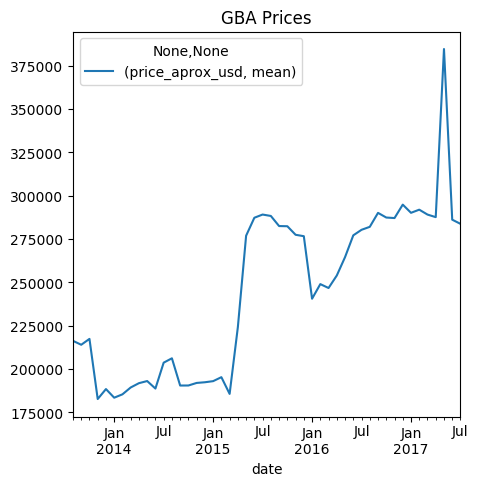

In [77]:
GBA.plot(x='date', y=('price_aprox_usd', 'mean') , kind='line', title="GBA Prices")

# Variacion de precios en funcion del tipo de propiedad en Gran Buenos Aires

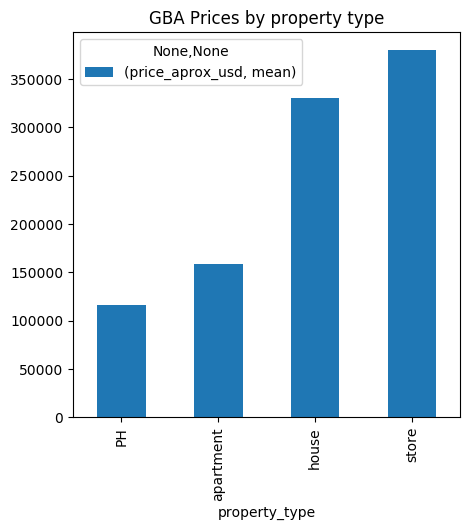

In [78]:
GBA = df.loc[df.place_with_parent_names.str.contains('Bs.As. G.B.A.'), :]
GBA = GBA.loc[:, ['property_type', 'price_aprox_usd']].groupby('property_type').agg([np.mean, np.size]).reset_index()
GBA.plot(x='property_type', y=('price_aprox_usd', 'mean') , kind='bar', title="GBA Prices by property type")

# Variacion de precios en funcion del tipo de propiedad en Capital Federal

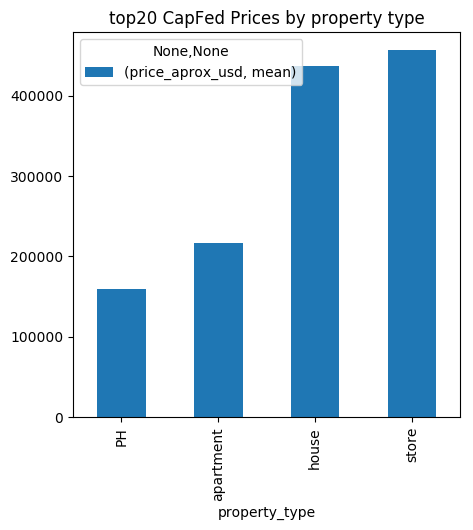

In [79]:
CF = df.loc[df.place_with_parent_names.str.contains('Capital Federal'), :]
CF = CF.loc[:, ['property_type', 'price_aprox_usd']].groupby('property_type').agg([np.mean, np.size]).reset_index()
CF.plot(x='property_type', y=('price_aprox_usd', 'mean') , kind='bar', title="top20 CapFed Prices by property type")

In [52]:
def ManhattanDistance(lat1, lon1, lat2, lon2):
    dlat = abs(lat1-lat2) * (10000/90) # pasamos la diferencia a metros (90° son 10000 Km)
    dlon = abs(lon1-lon2) * (40000/360) # pasamos la diferencia a metros (360° son 40000 Km)
    distKM = ( (dlat ** 2) + (dlon ** 2) ) ** (0.5)
    return float(distKM * 1000)
    """dlat = abs(lat1-lat2)
    dlon = abs(lon1-lon2)
    a = ((math.sin(dlat/2)) ** 2) + math.cos(lat1) * math.cos(lat2) * ((math.sin(dlon/2)) **2 )
    y = a ** (0.5)
    x = (1-a) ** (0.5)
    c = 2 * math.atan2(y, x)
    R = 6371 # Radio de la tierra en Km
    return R * c"""

In [191]:
def distanceAnalysis(df, extraDf, lat, lon, groupbyPlaceName=False):
    extraDf.loc[:, [lon]] = extraDf.loc[:, [lon]].apply(lambda x: float(x), axis = 1)
    extraDf.loc[:, [lat]] = extraDf.loc[:, [lat]].apply(lambda x: float(x), axis = 1)
    extraDf = extraDf[~np.isnan(extraDf[lon]) | ~np.isnan(extraDf[lat])]

    df = df[~np.isnan(df['lon']) | ~np.isnan(df['lat'])]
    df = df[~np.isnan(df['price_aprox_usd'])]
    if groupbyPlaceName:
        df = df.loc[:, ['lon', 'lat', 'price_aprox_usd', 'place_name']].groupby('place_name')\
        .agg([np.mean, np.size]).reset_index()
        df = df[~np.isnan(df[('lon', 'mean')]) | ~np.isnan(df[('lat', 'mean')])]
        
        aux = pd.DataFrame()
        aux['lon'] = df[('lon', 'mean')]
        aux['lat'] = df[('lat', 'mean')]
        aux['price_aprox_usd'] = df[('price_aprox_usd', 'mean')]
        aux['place_name'] = df['place_name']
        df = aux
    
    latDf = df['lat'].tolist()
    lonDf = df['lon'].tolist()
    x = extraDf[lon].tolist()
    y = extraDf[lat].tolist()

    distances = []
    minor = 0;

    for i in range(0, len(latDf)):
        minor = ManhattanDistance(y[0], x[0], latDf[i], lonDf[i])
        for j in range(1, len(x)):
            dist = ManhattanDistance(y[j], x[j], latDf[i], lonDf[i])
            if (dist < minor):
                minor = dist
        distances.append(minor)

    df['distances'] = pd.Series(distances)
    df = df.loc[:, ['distances', 'price_aprox_usd']].groupby('distances').agg([np.mean, np.size]).reset_index()
    df = df.sort_values(by=('distances', ''), ascending=True)
    df = df[~np.isnan(df[('price_aprox_usd', 'mean')])]
    df = df[df[('price_aprox_usd', 'mean')] > 0]
    df = df[df[('price_aprox_usd', 'size')] > 200]
    return df

In [192]:
subways = pd.read_csv('./extra/estaciones-de-subte.csv', low_memory=False)
CF = df.loc[df.place_with_parent_names.str.contains('Capital Federal'), :]
CF = CF[CF['place_name'] != "Capital Federal"]
CF = distanceAnalysis(df, subways, 'Y', 'X', False)

# Grafico De la densidad de la variacion del precio en funcion de la cercania a una parada de subte

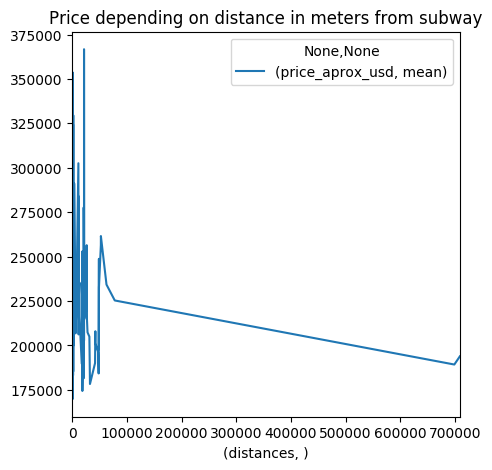

In [194]:
# Filtro Las distancias lejanas porque si no la escala no se ve favorecida para graficarlos puntos calculados
#CFPlot = CF[CF[('distances', '')] < 0.8*10**7]
#CFPlot = CFPlot[CFPlot[('price_aprox_usd', 'mean')] < 10**7]
CFPlot.plot(x=('distances', ''), y=('price_aprox_usd', 'mean') , kind='line', \
            title="Price depending on distance in meters from subway")

In [195]:
hospitals = pd.read_csv("./extra/hospitales.csv", low_memory=False, sep=';', error_bad_lines=False)
BsAs = distanceAnalysis(df, hospitals, 'LAT', 'LNG', False)

# Grafico De la densidad de la variacion del precio en funcion de la cercania a un hospital

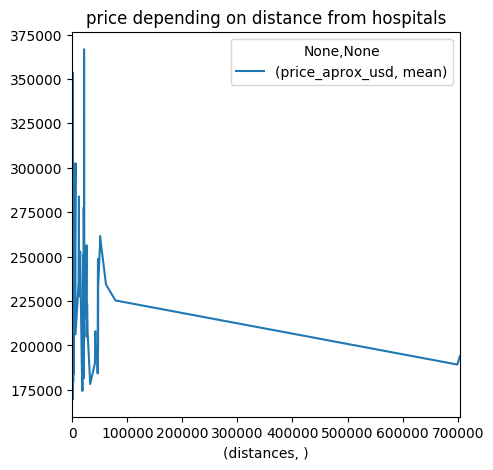

In [197]:
# Filtro Las distancias lejanas porque si no la escala no se ve favorecida para graficarlos puntos calculados
BsAsPlot = BsAs[BsAs[('distances', '')] < 10**7]
BsAsPlot = BsAsPlot[BsAsPlot[('price_aprox_usd', 'mean')] < 10**7]
BsAsPlot.plot(x=('distances', ''), y=('price_aprox_usd', 'mean') , kind='line', \
              title="price depending on distance from hospitals")

In [198]:
def changeStringCommaForPoint(string):
    point = "."
    split = string.split(',')
    return point.join(split)
def changeStringListCommaForPoint(stringList):
    aux = []
    for string in stringList:
        aux.append(changeStringCommaForPoint(string))
    return aux

In [199]:
busStops = pd.read_csv("./extra/paradas-de-colectivo.csv", low_memory=False, sep=';', error_bad_lines=False)
busStops['X'] = pd.Series(changeStringListCommaForPoint(busStops['X'].tolist()))
busStops['Y'] = pd.Series(changeStringListCommaForPoint(busStops['Y'].tolist()))
busStops.loc[:, 'X'] = busStops.loc[:, ['X']].apply(lambda x: float(x), axis = 1)
busStops.loc[:, 'Y'] = busStops.loc[:, ['Y']].apply(lambda x: float(x), axis = 1)

CF = df.loc[df.place_with_parent_names.str.contains('Capital Federal'), :]
CF = distanceAnalysis(CF, busStops, 'Y', 'X', True)

# Grafico De la densidad de la variacion del precio en funcion de la cercania a una parada de subte

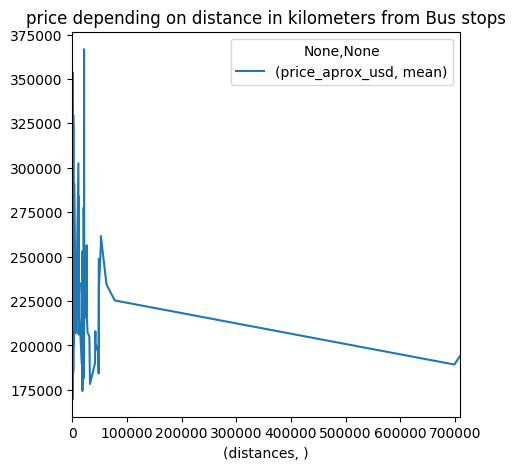

In [200]:
#CFPlot = CF[CF[('distances', '')] < 10000]
#CFPlot = CFPlot[CFPlot[('distances', '')] < 800000]
CFPlot.plot(x=('distances', ''), y=('price_aprox_usd', 'mean') , kind='line', \
        title="price depending on distance in kilometers from Bus stops")

# Grafico De la densidad de la variacion del precio en funcion de la cercania a las universidades

In [201]:
universities = pd.read_csv("./extra/universidades.csv", low_memory=False, sep=';', error_bad_lines=False)
#universities['LNG'] = pd.Series(changeStringListCommaForPoint(universities['LNG'].tolist()))
#universities['LAT'] = pd.Series(changeStringListCommaForPoint(universities['LAT'].tolist()))
universities.loc[:, 'LNG'] = universities.loc[:, ['LNG']].apply(lambda x: float(x), axis = 1)
universities.loc[:, 'LAT'] = universities.loc[:, ['LAT']].apply(lambda x: float(x), axis = 1)
universities = universities[~np.isnan(universities['LNG']) | ~np.isnan(universities['LAT'])]
BsAs = distanceAnalysis(df, universities, 'LAT', 'LNG', True)

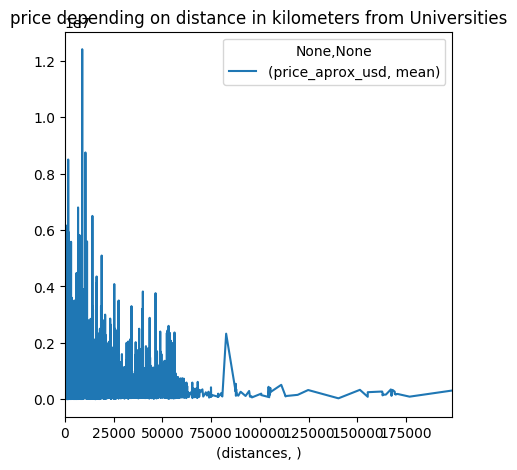

In [203]:
#BSASPlot = BSAS[BSAS[('distances', '')] < 200000]
BSASPlot.plot(x=('distances', ''), y=('price_aprox_usd', 'mean') , kind='line', title="price depending on distance in kilometers from Universities")

## Variacion de precio de las casas en funcion de la cantidad de ambientes

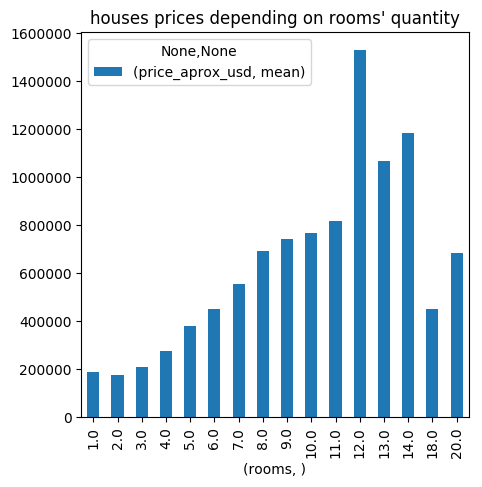

In [16]:
houses = df[df['property_type'] == 'house']
houses = houses[~np.isnan(houses['rooms'])]
houses = houses[houses['rooms'] != 0]
houses = houses.loc[:, ['rooms', 'price_aprox_usd']].groupby('rooms').agg([np.mean, np.size]).reset_index()
houses = houses[houses[('price_aprox_usd', 'size')] >= 10]
houses.plot(x=('rooms', ''), y=('price_aprox_usd', 'mean') , kind='bar', title="houses prices depending on rooms' quantity")

# Grafico de densidades de los barrios de capital federal en función de el precio promedio  en dolares

Estas tres funciones conviertes el dataFrame a geoDataFrame.

La primer funcion reemplaza las columnas lat y lon por una columna necesaria para el dataFrame la cual se llama
geometry. Esta contiene la latitud y longitud en forma de objeto Point que representa un punto o coordenada del mapa.

La segunda función recibe un dataFrame que representa un mapa, que puede ser la división por barrio de la capital Federal o la division por distritos escolares o por comuna, etc, y reemplaza la columna WKT que en general contiene una lista de poligonos, que representa un area, la columna geometry.

La tercer funcion convierte una lista de string de poligonos a el objetos de lista de objetos poligonos. Esto es necesario ya que la mayoria de los DataFrame que prepresentan algun tipo de mapa, vienen con este tipo de inconvenientes.

In [7]:
def convertToGeoData(df):
    geometry = [Point(xy) for xy in zip(df.lon, df.lat)]
    df = df.drop(['lat', 'lon'], axis = 1)
    crs = {'init': 'epsg:4326'}
    geoDf = gpd.GeoDataFrame(df, crs = crs, geometry = geometry)
    return geoDf
#--------------------------------------------------------------------
def convertToGeoDataFrame(df):
    geometry = [Polygon(x) for x in df['WKT'].tolist()] 
    crs = {'init': 'epsg:4326'}
    geoDf = gpd.GeoDataFrame(df, crs = crs, geometry = geometry)
    return geoDf
#--------------------------------------------------------------------
def convertStringToPolygon(listOfPolygons):
    import re
    finalList = []
    pat = re.compile(r'''(-*\d+\.\d+ -*\d+\.\d+);*''')
    for s in listOfPolygons:
        matches = pat.findall(s)
        if matches:
            finalList.append([tuple(map(float, m.split())) for m in matches])
    return finalList

La primer funcion realiza el filtrado y agrupamiento por barrio de capital federal del DataFrame de las propiedades. Se filtraron las proiedades con longitud y latitud con valor de Nan, y tambien aquellas longitudes y latitudes cuyos valores se encunetren en el rango que se ve en el código. Esto se hizo ya que a pesar de agrupar por barrio de la Capital Federal, hay propiedades que se encontraban por fuera de este rango que es el la Ciudad de buenos Aires pertenece. Es decir, que hay errores graves en el archivo CSV donde hay propiedades donde dicen ser de capital Federal pero su longitud y/o latitud no pertenecen al conjunto de las mismas que estan contenidas en Capital Federal.

La segunda funcion recibe dos GeoDataFrames, uno que contiene en su columna de goemetry una serie de objetos Points, que son coordenadas longitud, latitud en el mapa, y el otro contiene una serie de objetos Polygon.
Se itera por cada propiedad, que seria el primer geoDataFrame, y por cada Polygono se pregunta si elpunto pertenece. De esta manera se reemplaza la columna geometry del primer geoDataFrame de propiedades con una serie de Polygons de tal manera que queden las propiedades con su respetiva area de polygono que puede representar un barrio, una comuna o un distrito escolar.

In [8]:
def densityMapByPlaceName(df, place):
    densityMap = df
    if place == 'Capital Federal' or place == 'Bs.As. G.B.A.':
        densityMap = densityMap.loc[densityMap.place_with_parent_names.str.contains(place), :]
        
    densityMap = densityMap[~np.isnan(densityMap['lat']) | ~np.isnan(densityMap['lon'])]
    densityMap = densityMap[(densityMap['lon'] <= -58.0) & (densityMap['lon'] >= -58.55)]
    densityMap = densityMap[(densityMap['lat'] <= -34.530) & (densityMap['lat'] >= -34.73)]
    
    densityMap = densityMap.loc[:, ['place_name', 'price_aprox_usd', 'lat', 'lon']].groupby('place_name')\
    .agg([np.mean, np.size]).reset_index()
    
    aux = pd.DataFrame()
    aux['place_name'] = densityMap[('place_name', '')]
    aux['price_aprox_usd'] = densityMap[('price_aprox_usd', 'mean')]
    aux['lon'] = densityMap[('lon', 'mean')]
    aux['lat'] = densityMap[('lat', 'mean')]
    densityMap = aux
    
    densityMap = densityMap[~np.isnan(densityMap['price_aprox_usd'])]
    return densityMap
#----------------------------------------------------------------------------------------------
def belongToPolygon(geoDf, buenosAiresMap):
    polygons = []
    for point in geoDf['geometry'].tolist():
        for polygon in buenosAiresMap['geometry'].tolist():
            if polygon.contains(point):
                polygons.append(polygon)
                continue
    geoDf['geometry'] = gpd.GeoSeries(polygons)
    return geoDf

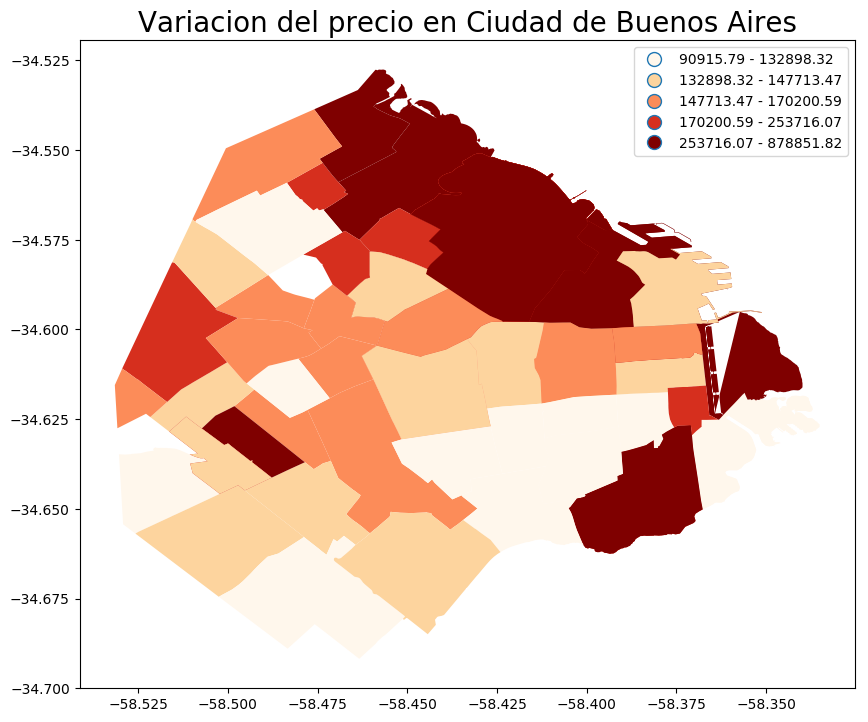

In [9]:
densityMapDf = densityMapByPlaceName(df, 'Capital Federal')
geoDf = convertToGeoData(densityMapDf)

buenosAires = pd.read_csv('barrios.csv', low_memory = False)
buenosAires['WKT'] = pd.Series(convertStringToPolygon(buenosAires['WKT'].tolist()))
buenosAiresMap = convertToGeoDataFrame(buenosAires)

geoDf = belongToPolygon(geoDf, buenosAiresMap)
geoDf.plot(legend=True, column = 'price_aprox_usd', cmap='OrRd', scheme="Quantiles", figsize=(10,10))
plt.title('Variacion del precio en Ciudad de Buenos Aires', fontsize = 20)

# Análisis de la variación de precios en función de la cercania a distritos escolares

En este análisis se tuvo en cuenta como se dstrinuyen los distritos escolares en el mapa de buenos aires. De esta manera se nota  que la división en el territorio que se ve en el mapa es distinta a la división real del mapa de los barrios del mismo. Se mezclaron los archivos de geoDataFrame de los distritos escolares y de las propiedades de tal manera se agrego a esta ultima el poligono que representa la división de distritos.

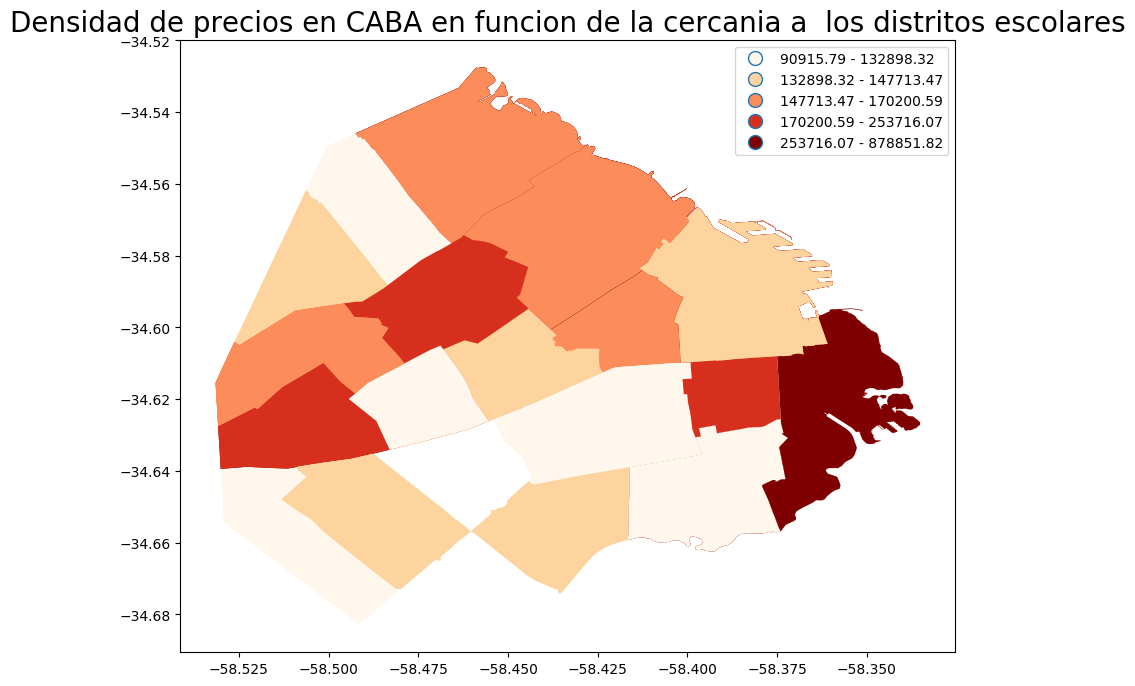

In [32]:
schoolDistricts = pd.read_csv("./extra/distritos-escolares.csv", low_memory=False, sep=',', error_bad_lines=False)
schoolDistricts['WKT'] = pd.Series(convertStringToPolygon(schoolDistricts['WKT'].tolist()))
schoolDistrictsMap = convertToGeoDataFrame(schoolDistricts)

NeiighbourgoodPrices = densityMapByPlaceName(df, 'Capital Federal')
geoDf = convertToGeoData(NeiighbourgoodPrices)
geoDf = belongToPolygon(geoDf, schoolDistricts)
geoDf.plot(legend=True, column = 'price_aprox_usd', cmap='OrRd', scheme="Quantiles", figsize=(10,10))
plt.title('Densidad de precios en CABA en funcion de la cercania a  los distritos escolares', fontsize = 20)